In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
# from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from torch import nn, optim
from torchvision import datasets
import matplotlib.pyplot as plt

import os
import cv2

import numpy as np
from PIL import Image
import glob

In [48]:
BATCH_SIZE = 64
LR = 1e-3
criterion = nn.CrossEntropyLoss() # softmax, crossEntropy 동시에
DEVICE =  "cuda" if torch.cuda.is_available() else "cpu" # gpu
EPOCH = 3

#  데이터 불러오기

In [4]:
os.chdir('/content/drive/MyDrive/24-1/딥러닝세션/dataset/unscaled')

In [5]:
train_dir = '/content/drive/MyDrive/24-1/딥러닝세션/dataset/unscaled/train'
test_dir = '/content/drive/MyDrive/24-1/딥러닝세션/dataset/unscaled/test'
print(len(os.listdir(train_dir))) # 몇 개의 이미지가 저장되어 있는지 확인
print(len(os.listdir(test_dir))) # 몇 개의 이미지가 저장되어 있는지 확인

25310
2469


In [6]:
train_files = (glob.glob(train_dir + '/*'))
test_files = (glob.glob(test_dir + '/*'))
print(train_files[:2])
print(test_files[:2])

['/content/drive/MyDrive/24-1/딥러닝세션/dataset/unscaled/train/cat.911.jpg', '/content/drive/MyDrive/24-1/딥러닝세션/dataset/unscaled/train/cat.9116.jpg']
['/content/drive/MyDrive/24-1/딥러닝세션/dataset/unscaled/test/7508.jpg', '/content/drive/MyDrive/24-1/딥러닝세션/dataset/unscaled/test/7526.jpg']


# 이미지 확인

### 1. cv2 사용방법

In [7]:
def read_img(file_path): # 이미지 읽는 함수
    img_arr =cv2.imread(file_path) # BGR 값을 배열 형태로 읽는다
    return cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB) # BGR 을 RGB 로 변환

### 2. PIL.Image 사용방법

In [8]:
def read_img_PIL(file_path) :
    img= Image.open(file_path)
    # print((img_arr)) # np.array 를 해줘야 이미지 배열 형태로 바뀐다.
    # np.array 를 해주지 않으면 그냥 이미지 인스턴스가 어디 메모리에 올라가 있는지만 나옴

    # 램 초과 이슈로 모든 이미지 사이즈 절반으로 줄이기
    width, height=img.size
    img_small = img.resize((int((width)/4),int((height)/4)))
    return np.array(img_small)

In [9]:
img_arrs=[]
img_num=3
for idx in range(img_num) :
    # print(read_img_PIL(train_files[idx]))
    img_arrs.append(read_img_PIL(train_files[idx]))
    img_arrs.append(read_img_PIL(test_files[idx]))
len(img_arrs)
print(type(img_arrs))
# 전체 배열은 list 형태이지만 각각의 원소들은 ndarray 형태임
# 전체 배열을 ndarray 형태로 하면 shape 이 안 맞기 때문

<class 'list'>


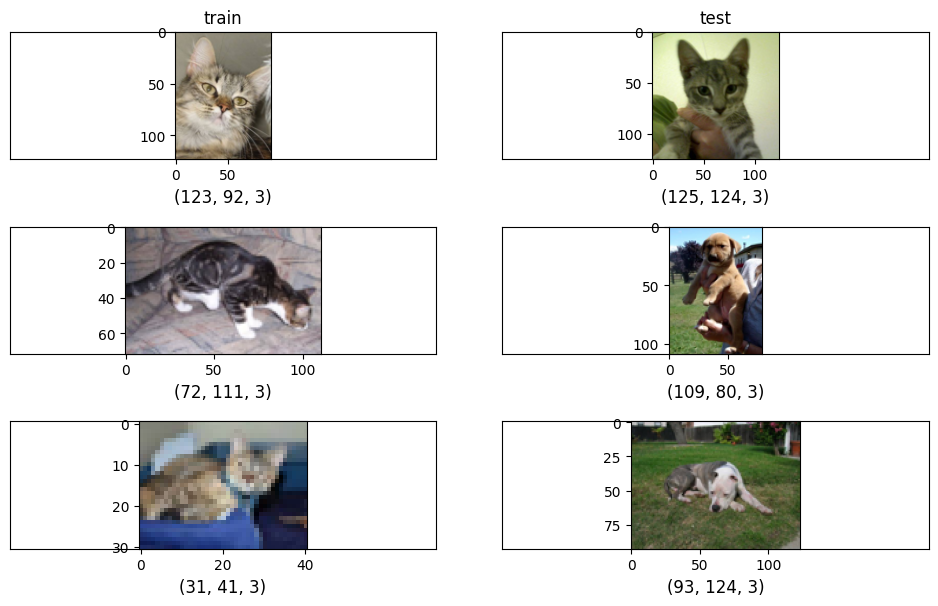

In [10]:
rows= 3
columns = 2

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*5, rows*2))
for num in range(1, rows*columns+1) :
    fig.add_subplot(rows,columns,num)
    idx = num-1
    plt.imshow(img_arrs[idx])
    plt.xlabel(f'{img_arrs[idx].shape}', fontsize=12)
fig.tight_layout() # 이미지 사이 간격 조정

cols = ['train', 'test']

# 제목 설정
for folder_idx, ax in enumerate(axes[0]):
    ax.set_title(cols[folder_idx])

for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

# 데이터 배열로 변환

In [11]:
train_x = []
train_y = []
test_x = []
test_y= []

In [12]:
# 파일명에서 dog, cat 언제 시작하니
# print(len('/content/drive/MyDrive/24-1/딥러닝세션/dataset/unscaled/train/'))
import time

start=time.time()

# 램 초과 이슈로 일단 5000개 테스트
for idx, i in enumerate(train_files[0:5000]):
    if(idx!=0 and idx%1000==0) :
        print(f'개수: {idx} 시간 {time.time()-start}') # 1000개 로드마다 시간 얼마나 걸리는지 체크
        start=time.time()
    train_x.append(read_img_PIL(i))
    if (i[65:68]=='dog') :
        train_y.append(1)
    else :
        train_y.append(0)

print(f'개수: {10000} 시간 {time.time()-start}') # 1000개 로드마다 시간 얼마나 걸리는지 체크

개수: 1000 시간 135.88564276695251
개수: 2000 시간 12.005576133728027
개수: 3000 시간 15.112289428710938
개수: 4000 시간 13.538445472717285
개수: 10000 시간 12.435744762420654


# Custom Dataset
## torchvision.transform 사용
~~ 안씀...,, ~~
- 파이토치의 이미지 데이터 전처리 및 데이터 증강을 위해 제공되는 모듈
Resize: 이미지의 크기를 조절합니다.
    - RandomResizedCrop: 이미지를 무작위로 자르고 크기를 조절합니다.
    - RandomHorizontalFlip: 이미지를 무작위로 수평으로 뒤집습니다.
    - RandomVerticalFlip: 이미지를 무작위로 수직으로 뒤집습니다.
    - ToTensor: 이미지를 텐서로 변환합니다.
    - Normalize: 이미지를 정규화합니다.
    - ColorJitter: 이미지의 색상을 무작위로 조정합니다.
    - RandomRotation: 이미지를 무작위로 회전합니다.
    - RandomCrop: 이미지를 무작위로 자릅니다.
    - Grayscale: 이미지를 흑백으로 변환합니다.
    - RandomSizedCrop: 이미지를 무작위로 자르고 크기를 조절합니다.
    
    https://wikidocs.net/194919

In [13]:
# 가장 큰 y, x 쌍에 맞춰 나머지 이미지들을 padding 할 것이므로 max_y , max_x 추출
# for i in train_x :
# print(train_x[0].shape) # (행, 열, 채널)
# print(len(train_x[0][0]))
max_row= max(len(x) for x in train_x)
max_col=max(len(x[0]) for x in train_x)
max_row, max_col

(192, 255)

# Padding 함수

In [14]:
# transforms 는 array나 리스트가 아닌 텐서 형태만 받을 수 있는데 리스트의 원소들은 서로 같은 길이를 갖고 있어야함
# 서로 다른 이미지 규격이기 때문에 padding 을 transfrom 안에서 하는게 아니라 밖에서 해준다
# 가장 큰 이미지에 맞춰 상하좌우 똑같이 패딩해줌
for idx, img in enumerate(train_x):
    height,width = img.shape[0:2]
    margin_width = [(max_col-width)//2]*2
    margin_height= [(max_row-height)//2]*2
    margin_rgb= [0,0]
    if((max_row-height)%2!=0) :
        margin_height[0]+=1
    if((max_col-width)%2!=0) :
        margin_width[0]+=1
    margin=[]
    margin.append(margin_height)
    margin.append(margin_width)
    margin.append(margin_rgb)
    output = np.pad(img, margin, mode = 'constant', constant_values=0)
    train_x[idx]=output

In [15]:
train_x= np.array(train_x)

### 잘 패딩 되었는지 이미지 확인

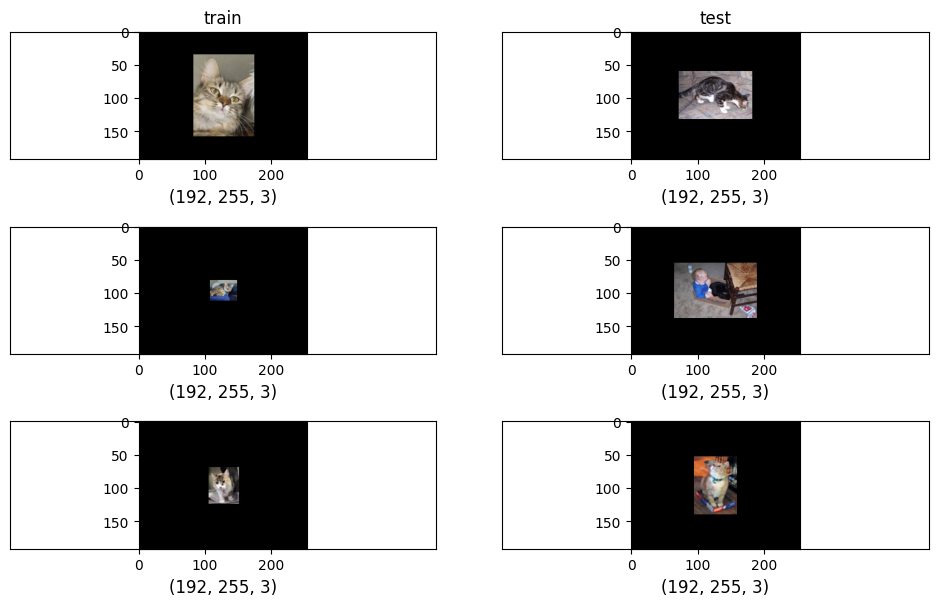

In [16]:
rows= 3
columns = 2

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*5, rows*2))
for num in range(1, rows*columns+1) :
    fig.add_subplot(rows,columns,num)
    idx = num-1
    plt.imshow(train_x[idx])
    plt.xlabel(f'{train_x[idx].shape}', fontsize=12)
fig.tight_layout() # 이미지 사이 간격 조정

cols = ['train', 'test']

# 제목 설정
for folder_idx, ax in enumerate(axes[0]):
    ax.set_title(cols[folder_idx])

for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

In [17]:
print(train_x.shape)

(5000, 192, 255, 3)


# CusomDataset

In [18]:
class CustomDataset(Dataset):
    def __init__(self, x, y, transform= None):
        self.x=torch.Tensor(x)
        self.y=y
        self.x = self.x.permute(0,3,1,2)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):

        return self.x[idx]/255,self.y[idx]

In [19]:
t_x= CustomDataset(train_x, train_y)

In [49]:
t_dl = DataLoader(t_x, batch_size=BATCH_SIZE, shuffle=True)

# Dataset 확인

torch.Size([32, 3, 192, 255])


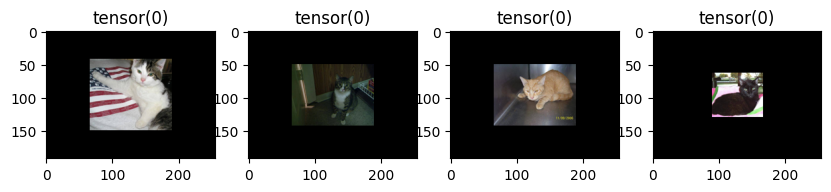

In [21]:
x_batch, y_batch=next(iter(t_dl)) # 한 iter 마다 32개씩
print(x_batch.shape) # 형태 점검 -> imshow 에서 permute 해야됨

# 데이터 시각화
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(10,2))

# 0이면 강아지, 1이면 고양이
ax1.imshow(x_batch[0].permute(1,2,0), cmap='gray')
ax1.set_title(y_batch[0])

ax2.imshow(x_batch[1].permute(1,2,0), cmap='gray')
ax2.set_title(y_batch[1])

ax3.imshow(x_batch[2].permute(1,2,0), cmap='gray')
ax3.set_title(y_batch[2])

ax4.imshow(x_batch[3].permute(1,2,0), cmap='gray')
ax4.set_title(y_batch[3])

plt.show()

# 모델

In [51]:
class CNN_deep(nn.Module): ## CNN과 FullyConnected layer 를 혼합하여 사용

    def __init__(self):

        super().__init__()

        self.conv_block1 = nn.Sequential(nn.Conv2d(3,6,3,padding=1),
                                         nn.BatchNorm2d(6),
                                         nn.ReLU(),
                                         nn.Conv2d(6,6,5,padding=1),
                                         nn.BatchNorm2d(6),
                                         nn.ReLU())
        # pooling layer
        self.Maxpool1 = nn.MaxPool2d(2)

        # 마지막은 fc classifier로
        self.classifier = nn.Sequential(nn.Linear(95*126*6,20),
                                        nn.Linear(20,10),
                                        nn.Linear(10,2))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)

        x = torch.flatten(x, start_dim=1) # flatten 으로 채널 개수 맞추기
        x = self.classifier(x)
        return x


In [35]:
train_acc=[]
test_acc=[]
valid_acc=[]

train_loss=[]
test_loss=[]
valid_loss=[]

# 훈련 함수 매개변수로, model(params..), train_DL, loss 함수, optimizer를 받습니다
def Train(model, train_DL, criterion, optimizer) :

    # EPOCH 마다 loss 값을 담아 loss_history를 리턴하도록 하였습니다.
    NoT = len(train_DL.dataset) # train 데이터 총 갯수
    model.train() # model 을 train 모드로 변경

    for ep in range(EPOCH):
        rloss = 0 # running loss
        rcorrect = 0
        for x_batch, y_batch in train_DL :
            x_batch= x_batch.to(DEVICE)
            y_batch= y_batch.to(DEVICE)
            # print(len(x_batch), len(train_DL.dataset)) 32, 30000
            y_hat = model(x_batch) # 모델을 돌렸을 때 나온 값

            loss = criterion(y_hat, y_batch)
            # 모델의 예측값과 정답 값을 crossentropyloss를 이용해 구한다
            # 엔트로피 값이 클수록 분류가 제대로 안 된 것이므로 부정확하다

            optimizer.zero_grad() # 반복 때마다 기울기를 새로 계산해야하므로 기울기 초기화
            loss.backward() # 역전파 알고리즘 계산
            optimizer.step() # 계산한 기울기를 adam 알고리즘에 맞추어 가중치를 수정

            pred = y_hat.argmax(dim = 1) # 가장 높게 나온 라벨 추출
            loss_b = loss.item() * x_batch.shape[0] # batch loss, Batch_Size를 곱하지 않는 이유는 마지막 데이터의 갯수를 모르기 때문입니다.

            rloss += loss_b
            corrects_t = torch.sum(pred==y_batch).item() # 맞게 나온 데이터 갯수
            rcorrect += corrects_t



        accuracy_t = rcorrect/len(train_DL.dataset)
        # print loss
        loss_e = rloss/NoT # loss per epoch
        train_loss.append(loss_e)
        print(f"Epoch: {ep+1}, train loss: {round(loss_e,3)}, Train Accuracy: {round(accuracy_t,4)}", end = ' ')
        train_acc.append(accuracy_t)
        print("-"*20)


In [52]:
model = CNN_deep().to(DEVICE)
Train(model, t_dl, criterion, optim.Adam(model.parameters(), LR))

Epoch: 1, train loss: 0.008, Train Accuracy: 0.9968 --------------------
Epoch: 2, train loss: 0.0, Train Accuracy: 1.0 --------------------
Epoch: 3, train loss: 0.0, Train Accuracy: 1.0 --------------------
